# Etude de l'évolution temporelle du centre galactique

On effectue l'analyse 2D en séparant les observations par année.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

In [2]:
# Define which data to use and print some information
data_store = DataStore.from_dir("$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/samuel/code/gammapy_data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 122853
OBS_ID: 18092 -- 151486
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 20485



In [22]:
# modification des colonnes TSTART et TSTOP dans l'obs-index

#FAIT

from astropy.time import Time                                                                                                            
from astropy.table import Table                                                                                                          

table=Table.read("../../data/ash_stereo_Prod17_Calib0834_thsq64/obs-index.fits.gz")                                        

from gammapy.utils.time import time_relative_to_ref                                                                                      

tstart = time_relative_to_ref(Time(table['TSTART_STR'],scale='utc'), table.meta)                                                         

tstop = time_relative_to_ref(Time(table['TSTOP_STR'],scale='utc'), table.meta)                                                          

table['TSTART'][:]=tstart.to('s')                                                                                                       

table['TSTOP'][:]=tstop.to('s')                                                                                                         

table.write("obs-index.fits.gz", overwrite=True)

In [26]:
%%time

# modification des fichiers edisp
import glob
listfile = glob.glob("../../data/ash_stereo_Prod17_Calib0834_thsq64/run*/run*/*edisp*")

# FAIT

from astropy.io import fits
for filename in listfile:
    hdul = fits.open(filename)
    hdul[1].header['TUNIT7']=''
    hdul.writeto(filename, overwrite=True)

CPU times: user 1min 32s, sys: 46.3 s, total: 2min 18s
Wall time: 5min 47s


In [4]:
from astropy.coordinates import Angle


selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(2, 'deg'),
                 border=Angle(0, 'deg'))

obs_table = data_store.obs_table.select_observations(selection)

In [3]:
t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

In [28]:
# étrange

obs_table2004 = obs_table.select_observations(t2004)
ids = obs_table2004["OBS_ID"].tolist()
obs2004 = data_store.get_observations(ids, skip_missing=True)


obs_table2005 = obs_table.select_observations(t2005)
ids = obs_table2005["OBS_ID"].tolist()
obs2005 = data_store.get_observations(ids, skip_missing=True)


obs_table2006 = obs_table.select_observations(t2006)
ids = obs_table2006["OBS_ID"].tolist()
obs2006 = data_store.get_observations(ids, skip_missing=True)


obs_table2007 = obs_table.select_observations(t2007)
ids = obs_table2007["OBS_ID"].tolist()
obs2007 = data_store.get_observations(ids, skip_missing=True)


obs_table2008 = obs_table.select_observations(t2008)
ids = obs_table2008["OBS_ID"].tolist()
obs2008 = data_store.get_observations(ids, skip_missing=True)


obs_table2009 = obs_table.select_observations(t2009)
ids = obs_table2009["OBS_ID"].tolist()
obs2009 = data_store.get_observations(ids, skip_missing=True)


obs_table2010 = obs_table.select_observations(t2010)
ids = obs_table2010["OBS_ID"].tolist()
obs2010 = data_store.get_observations(ids, skip_missing=True)


obs_table2011 = obs_table.select_observations(t2011)
ids = obs_table2011["OBS_ID"].tolist()
obs2011 = data_store.get_observations(ids, skip_missing=True)


obs_table2012 = obs_table.select_observations(t2012)
ids = obs_table2012["OBS_ID"].tolist()
obs2012 = data_store.get_observations(ids, skip_missing=True)


obs_table2013 = obs_table.select_observations(t2013)
ids = obs_table2013["OBS_ID"].tolist()
obs2013 = data_store.get_observations(ids, skip_missing=True)


obs_table2014 = obs_table.select_observations(t2014)
ids = obs_table2014["OBS_ID"].tolist()
obs2014 = data_store.get_observations(ids, skip_missing=True)


obs_table2015 = obs_table.select_observations(t2015)
ids = obs_table2015["OBS_ID"].tolist()
obs2015 = data_store.get_observations(ids, skip_missing=True)


obs_table2016 = obs_table.select_observations(t2016)
ids = obs_table2016["OBS_ID"].tolist()
obs2016 = data_store.get_observations(ids, skip_missing=True)


obs_table2017 = obs_table.select_observations(t2017)
ids = obs_table2017["OBS_ID"].tolist()
obs2017 = data_store.get_observations(ids, skip_missing=True)


obs_table2018 = obs_table.select_observations(t2018)
ids = obs_table2018["OBS_ID"].tolist()
obs2018 = data_store.get_observations(ids, skip_missing=True)


obs_table2019 = obs_table.select_observations(t2019)
ids = obs_table2019["OBS_ID"].tolist()
obs2019 = data_store.get_observations(ids, skip_missing=True)

In [5]:
year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

yearly_obs = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store.get_observations(ids, skip_missing=True)
    
    for obs in observations_year:
        try:
            obs.aeff
            obs.edisp
            obs.psf
        except:
            ids.remove(obs.obs_id)
            print("Observation retirée : " + str(obs.obs_id))
            
    observations_year = data_store.get_observations(ids, skip_missing=True)
    yearly_obs[year] = observations_year
    
#obs2004, obs2005, obs2006, obs2007, obs2008, obs2009, obs2010, obs2011, obs2012, obs2013, obs2014, obs2015, obs2016, obs2017, obs2018, obs2019 = yearly_obs

Found multiple HDU matching: OBS_ID = 20191, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20193, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20194, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss


Observation retirée : 20191
Observation retirée : 20193
Observation retirée : 20194
Observation retirée : 31539
Observation retirée : 31577
Observation retirée : 31578
Observation retirée : 31579
Observation retirée : 31580


## Les bins en énergie et espace

In [6]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

energy_axis_true = MapAxis.from_bounds(
    0.1, 200, 20, unit="TeV", name="energy", interp="log"
)

# peut être utilisée dans mapmaker si on veut
geom_true = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis_true],
)

## Création des MapDatasetMaker

In [7]:
%%time

# trouver un moyen simple pour faire les 15 années d'un coup
# dictionnaire ?
# mapdataset2004 = MapDataset.create(
#     geom=geom, energy_axis_true=energy_axis_true, name="map2004")

mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

CPU times: user 104 ms, sys: 20 ms, total: 124 ms
Wall time: 123 ms


In [8]:
%%time

for year in range(2004,2020):
    
    offset_max = 2.5 * u.deg
    maker = MapDatasetMaker()
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

    spectrum = PowerLaw2SpectralModel(index=2.3)

    for obs in yearly_obs[year]:
        # First a cutout of the target map is produced
        cutout = mapdataset_dict[year].cutout(obs.pointing_radec, width=2 * offset_max)

        # A MapDataset is filled in this cutout geometry
        dataset = maker.run(cutout, obs)

        # The data quality cut is applied
        dataset = maker_safe_mask.run(dataset, obs)

        # The resulting dataset cutout is stacked onto the final one
        mapdataset_dict[year].stack(dataset)

KeyboardInterrupt: 

In [31]:
offset_max = 2.5 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

spectrum = PowerLaw2SpectralModel(index=2.3)

for obs in yearly_obs[2019]:
        # First a cutout of the target map is produced
        cutout = mapdataset_dict[2019].cutout(obs.pointing_radec, width=2 * offset_max)

        # A MapDataset is filled in this cutout geometry
        dataset = maker.run(cutout, obs)

        # The data quality cut is applied
        dataset = maker_safe_mask.run(dataset, obs)

        # The resulting dataset cutout is stacked onto the final one
        mapdataset_dict[2019].stack(dataset)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x11e332b70>)

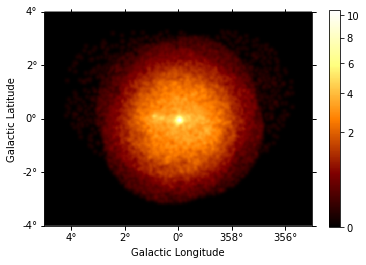

In [32]:
# On vérifie les cartes

mapdataset_dict[2019].counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    stretch="sqrt", add_cbar=True
)

In [54]:
# Sauvegarde

from pathlib import Path

path = Path("$GAMMAPY_DATA/mapdataset_hess/second_try")
path.mkdir(exist_ok=True)

for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/second_try/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year].write(filename, overwrite=True)

In [109]:
# write maps OBSOLETE
maps2D2004["counts"].write(str(path / "counts2004.fits"), overwrite=True)
maps2D2004["background"].write(str(path / "background2004.fits"), overwrite=True)
maps2D2004["exposure"].write(str(path / "exposure2004.fits"), overwrite=True)

maps2D2005["counts"].write(str(path / "counts2005.fits"), overwrite=True)
maps2D2005["background"].write(str(path / "background2005.fits"), overwrite=True)
maps2D2005["exposure"].write(str(path / "exposure2005.fits"), overwrite=True)

maps2D2006["counts"].write(str(path / "counts2006.fits"), overwrite=True)
maps2D2006["background"].write(str(path / "background2006.fits"), overwrite=True)
maps2D2006["exposure"].write(str(path / "exposure2006.fits"), overwrite=True)

maps2D2007["counts"].write(str(path / "counts2007.fits"), overwrite=True)
maps2D2007["background"].write(str(path / "background2007.fits"), overwrite=True)
maps2D2007["exposure"].write(str(path / "exposure2007.fits"), overwrite=True)

maps2D2008["counts"].write(str(path / "counts2008.fits"), overwrite=True)
maps2D2008["background"].write(str(path / "background2008.fits"), overwrite=True)
maps2D2008["exposure"].write(str(path / "exposure2008.fits"), overwrite=True)

maps2D2009["counts"].write(str(path / "counts2009.fits"), overwrite=True)
maps2D2009["background"].write(str(path / "background2009.fits"), overwrite=True)
maps2D2009["exposure"].write(str(path / "exposure2009.fits"), overwrite=True)

maps2D2010["counts"].write(str(path / "counts2010.fits"), overwrite=True)
maps2D2010["background"].write(str(path / "background2010.fits"), overwrite=True)
maps2D2010["exposure"].write(str(path / "exposure2010.fits"), overwrite=True)

maps2D2011["counts"].write(str(path / "counts2011.fits"), overwrite=True)
maps2D2011["background"].write(str(path / "background2011.fits"), overwrite=True)
maps2D2011["exposure"].write(str(path / "exposure2011.fits"), overwrite=True)

maps2D2012["counts"].write(str(path / "counts2012.fits"), overwrite=True)
maps2D2012["background"].write(str(path / "background2012.fits"), overwrite=True)
maps2D2012["exposure"].write(str(path / "exposure2012.fits"), overwrite=True)

maps2D2013["counts"].write(str(path / "counts2013.fits"), overwrite=True)
maps2D2013["background"].write(str(path / "background2013.fits"), overwrite=True)
maps2D2013["exposure"].write(str(path / "exposure2013.fits"), overwrite=True)

maps2D2014["counts"].write(str(path / "counts2014.fits"), overwrite=True)
maps2D2014["background"].write(str(path / "background2014.fits"), overwrite=True)
maps2D2014["exposure"].write(str(path / "exposure2014.fits"), overwrite=True)

maps2D2015["counts"].write(str(path / "counts2015.fits"), overwrite=True)
maps2D2015["background"].write(str(path / "background2015.fits"), overwrite=True)
maps2D2015["exposure"].write(str(path / "exposure2015.fits"), overwrite=True)

maps2D2016["counts"].write(str(path / "counts2016.fits"), overwrite=True)
maps2D2016["background"].write(str(path / "background2016.fits"), overwrite=True)
maps2D2016["exposure"].write(str(path / "exposure2016.fits"), overwrite=True)

maps2D2017["counts"].write(str(path / "counts2017.fits"), overwrite=True)
maps2D2017["background"].write(str(path / "background2017.fits"), overwrite=True)
maps2D2017["exposure"].write(str(path / "exposure2017.fits"), overwrite=True)

maps2D2018["counts"].write(str(path / "counts2018.fits"), overwrite=True)
maps2D2018["background"].write(str(path / "background2018.fits"), overwrite=True)
maps2D2018["exposure"].write(str(path / "exposure2018.fits"), overwrite=True)

maps2D2019["counts"].write(str(path / "counts2019.fits"), overwrite=True)
maps2D2019["background"].write(str(path / "background2019.fits"), overwrite=True)
maps2D2019["exposure"].write(str(path / "exposure2019.fits"), overwrite=True)

In [110]:
%%time

# Encore d'actualité ? a priori non

def Calculate_psf_kernel(obs, maps2D):
    geom2d = maps2D["exposure"].geom
    table_psf = make_mean_psf(obs, src_pos)

    table_psf_2d = table_psf.table_psf_in_energy_band((emin, emax), spectrum=spectrum)

    # PSF kernel used for the model convolution
    psf_kernel = PSFKernel.from_table_psf(table_psf_2d, geom2d, max_radius="0.3 deg")
    return psf_kernel

psf_kernel2004 = Calculate_psf_kernel(obs2004, maps2D2004)
psf_kernel2005 = Calculate_psf_kernel(obs2004, maps2D2005)
psf_kernel2006 = Calculate_psf_kernel(obs2004, maps2D2006)
psf_kernel2007 = Calculate_psf_kernel(obs2004, maps2D2007)
psf_kernel2008 = Calculate_psf_kernel(obs2004, maps2D2008)
psf_kernel2009 = Calculate_psf_kernel(obs2004, maps2D2009)
psf_kernel2010 = Calculate_psf_kernel(obs2004, maps2D2010)
psf_kernel2011 = Calculate_psf_kernel(obs2004, maps2D2011)
psf_kernel2012 = Calculate_psf_kernel(obs2004, maps2D2012)
psf_kernel2013 = Calculate_psf_kernel(obs2004, maps2D2013)
psf_kernel2014 = Calculate_psf_kernel(obs2004, maps2D2014)
psf_kernel2015 = Calculate_psf_kernel(obs2004, maps2D2015)
psf_kernel2016 = Calculate_psf_kernel(obs2004, maps2D2016)
psf_kernel2017 = Calculate_psf_kernel(obs2004, maps2D2017)
psf_kernel2018 = Calculate_psf_kernel(obs2004, maps2D2018)
psf_kernel2019 = Calculate_psf_kernel(obs2004, maps2D2019)

CPU times: user 4min 11s, sys: 5.77 s, total: 4min 17s
Wall time: 4min 37s


# Le modèle pour la source

In [19]:
%%time
# lecture

mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/second_try/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(filename)

CPU times: user 1min 5s, sys: 924 ms, total: 1min 5s
Wall time: 1min 5s


In [13]:
# Modèle de la source

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

spatial_model = PointSpatialModel(
            lon_0 = src_pos.l, 
            lat_0 = src_pos.b, 
            frame = "galactic")

spectral_model = PowerLaw2SpectralModel(
            emin = emin, 
            emax = emax, 
            index = 2.3, 
            amplitude = "3e-12 cm-2 s-1")

model = SkyModel(
            spatial_model = spatial_model, 
            spectral_model = spectral_model, 
            name = "SgrA*")

model.parameters["index"].frozen = True
model.parameters["lon_0"].frozen = True
model.parameters["lat_0"].frozen = True

In [21]:
for year in range(2004,2020):
    mapdataset_dict[year].models = model.copy()

In [20]:
print(mapdataset_dict[2004])

MapDataset

    Name                            :  

    Total counts                    : 360298 
    Total predicted counts          : 336524.70
    Total background counts         : 336524.70

    Exposure min                    : 1.04e+05 m2 s
    Exposure max                    : 1.06e+11 m2 s

    Number of total bins            : 4000000 
    Number of fit bins              : 2456840 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : 900621.35

    Number of models                : 1 
    Number of parameters            : 3
    Number of free parameters       : 1

    Component 0: 
        Name                        : background
        Type                        : BackgroundModel
        Parameters:
            norm                    : 1.000  
            tilt         (frozen)   : 0.000  
            reference    (frozen)   : 1.000  TeV




In [22]:
%%time

results_per_year = dict()
fit_year = dict()

for year in range(2004,2020):
    fit = Fit([mapdataset_dict[year]])
    result = fit.run()
    
    results_per_year[year] = result
    fit_year[year] = fit
    
    #print(result)

# pour visualiser les valeurs des paramêtres 
#result.parameters.to_table() 

# utile d'écrire les fichiers fit en .fits.gz et 

CPU times: user 34.4 s, sys: 5.14 s, total: 39.6 s
Wall time: 39.6 s


In [89]:
# problème pour écrire les fit

from pathlib import Path

path = Path("../../data/mapdataset_hess/second_try/fit")
path.mkdir(exist_ok=True)

for year in range(2004,2020):
    
    filename = "../../data/mapdataset_hess/second_try/fit/fitted_mapdataset"+str(year)+".fits.gz"
    fit_year[year].write(filename, overwrite=True)

AttributeError: 'Fit' object has no attribute 'write'

(<matplotlib.axes._subplots.WCSAxesSubplot at 0x7f405cc5ff98>, None)

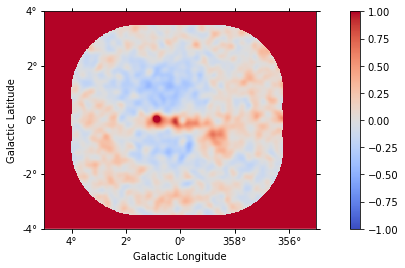

In [23]:
# visualisation des résidus

mapdataset_dict[2004].plot_residuals(method="diff/sqrt(model)", vmin=-1.0, vmax=1.0)

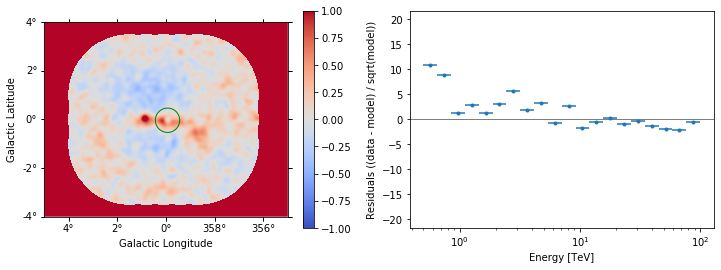

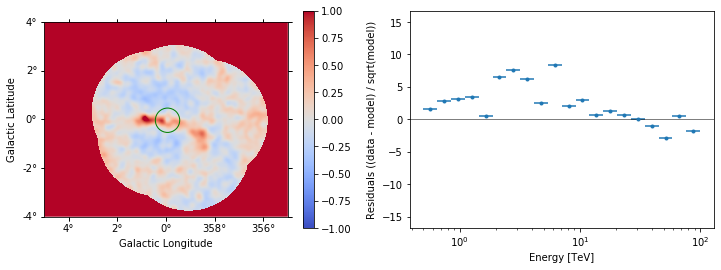

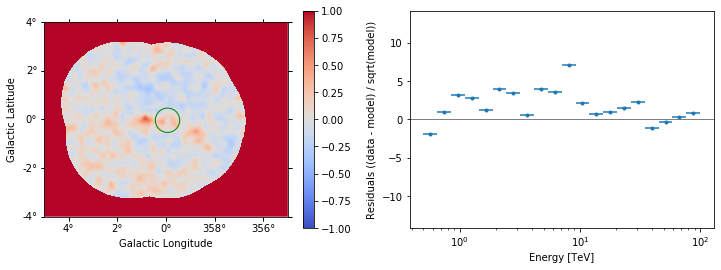

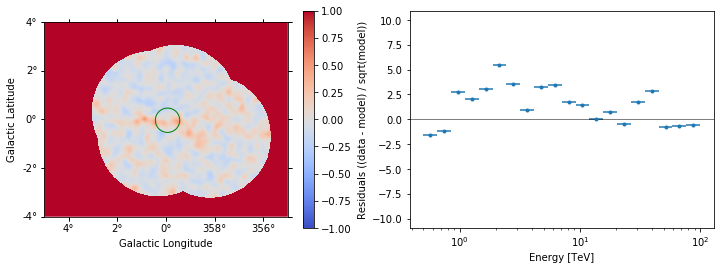

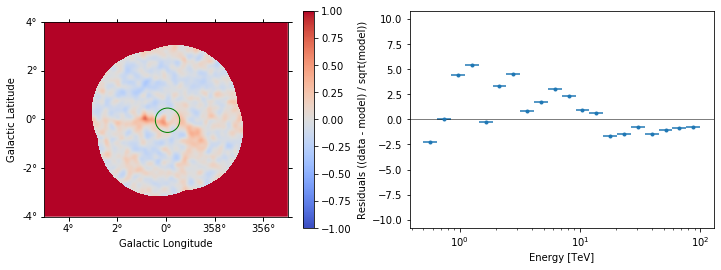

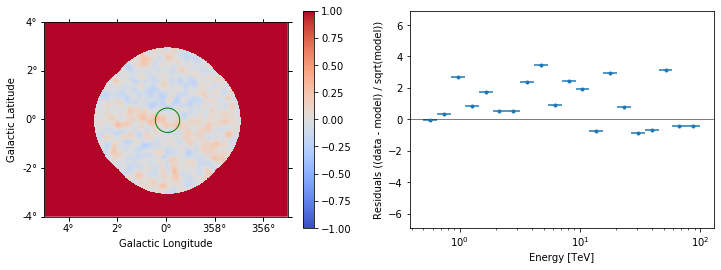

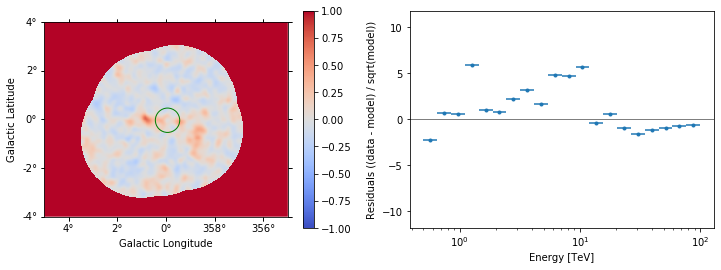

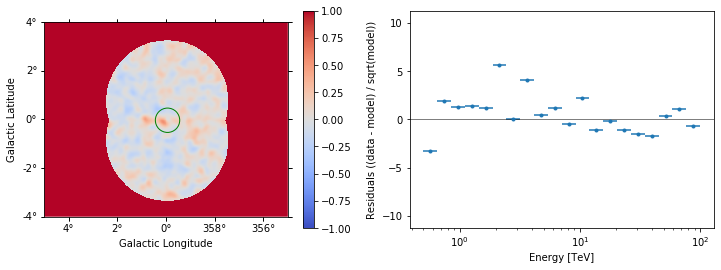

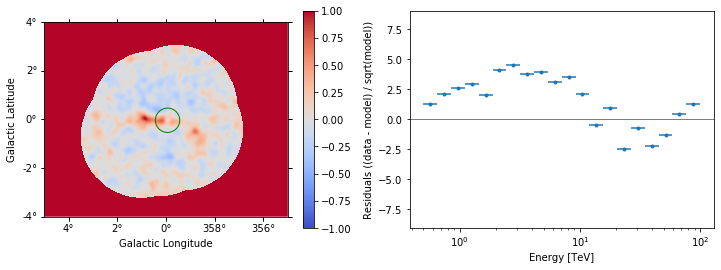

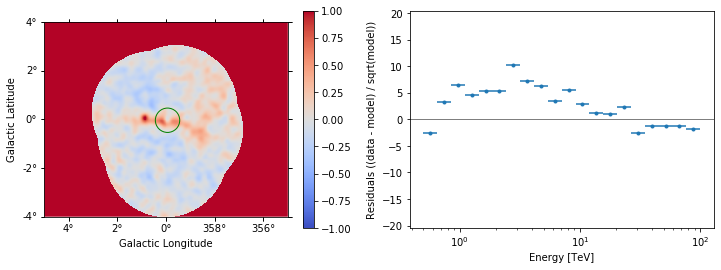

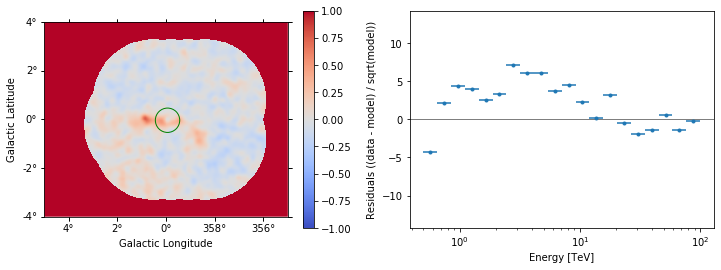

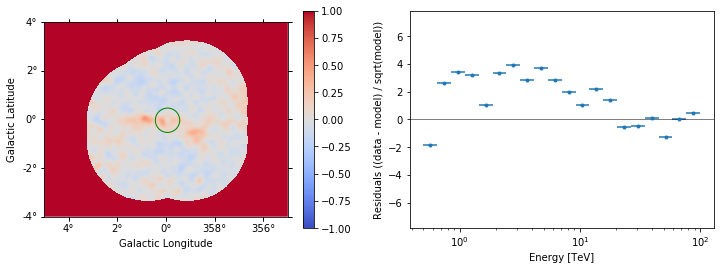

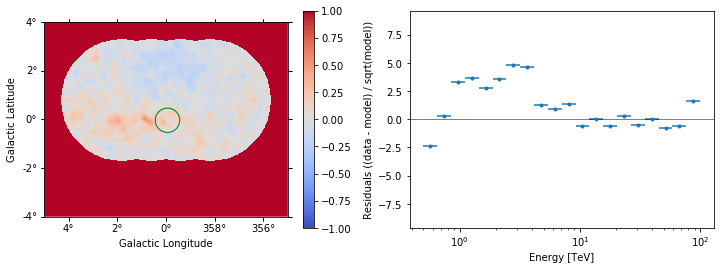

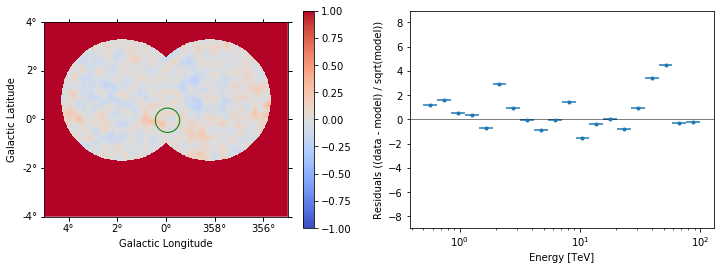

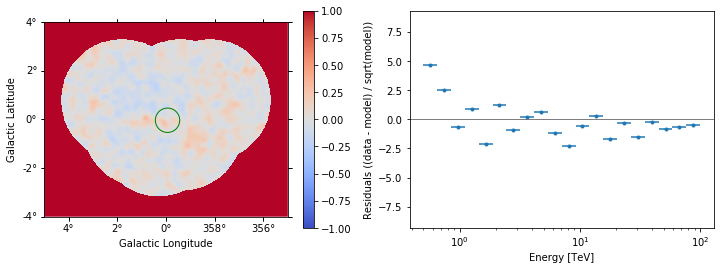

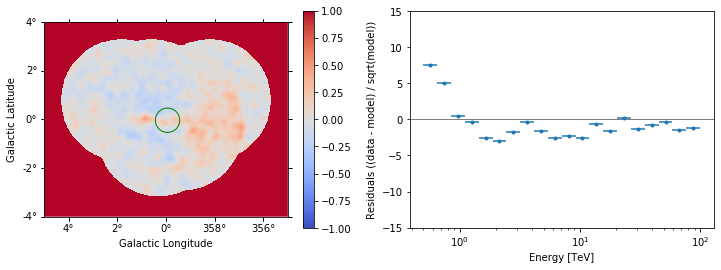

In [33]:
# truc étrange

region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

for year in range(2004,2020):
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    
plt.savefig("../../../images_gammapy/0.15/residuals_second_try/residuals.pdf")

## Inspecting fit statistic profiles

To check the quality of the fit it is also useful to plot fit statistic profiles for specific parameters. For this we use ~gammapy.modeling.Fit.stat_profile().

In [71]:
profile2004 = fit_year[2004].stat_profile(parameter="amplitude")
fit=fit_year[2004]
prof=fit.stat_profile(parameter="amplitude", bounds=5, nvalues=30)

For a good fit and error estimate the profile should be parabolic, if we plot it:

In [80]:
results_per_year[2006].parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str8,float64,float64,bool
lon_0,3.599e+02,1.796e-03,deg,nan,nan,False
lat_0,-3.935e-02,1.854e-03,deg,-9.000e+01,9.000e+01,False
amplitude,4.122e-12,1.613e-13,cm-2 s-1,nan,nan,False
index,2.000e+00,0.000e+00,,nan,nan,True
emin,5.000e-01,0.000e+00,TeV,nan,nan,True
emax,1.000e+02,0.000e+00,TeV,nan,nan,True
norm,1.038e+00,2.850e-03,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


Text(0, 0.5, 'Delta TS')

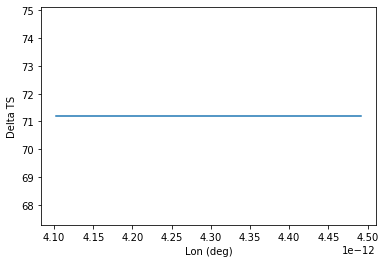

In [68]:
total_stat2004 = results_per_year[2004].total_stat
plt.plot(profile2004["values"], profile2004["stat"] - total_stat2004)
plt.xlabel("Lon (deg)")
plt.ylabel("Delta TS")

# Plot the fitted spectrum

## Making a butterfly plot

The SpectralModel component can be used to produce a, so-called, butterfly plot showing the enveloppe of the model taking into account parameter uncertainties.

To do so, we have to copy the part of the covariance matrix stored on the FitResult on the model parameters:

In [34]:
spec = model.spectral_model

# set covariance on the spectral model
covar = results_per_year[2004].parameters.get_subcovariance(spec.parameters)
spec.parameters.covariance = covar

ValueError: Parameter(name='amplitude', value=3e-12, factor=3e-12, scale=1.0, unit=Unit("1 / (cm2 s)"), min=nan, max=nan, frozen=False, id=0x7f405d57f1d0) is not in list

Now we can actually do the plot using the plot_error method:

In [ ]:
energy_range = [1, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)

# Computing flux points

We can now compute some flux points using the ~gammapy.spectrum.FluxPointsEstimator.

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name.

In [49]:
from gammapy.spectrum import FluxPointsEstimator

e_edges = [1, 2, 4, 10] * u.TeV

fpe = FluxPointsEstimator(datasets=[mapdataset_dict[2004]], e_edges=e_edges, source="SgrA*")

NameError: name 'FluxPointsEstimator' is not defined

In [ ]:
%%time
flux_points = fpe.run()

In [ ]:
ax = spec.plot_error(energy_range=energy_range, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

# Ring background

On a juste besoin des classes 'observations' pour ça

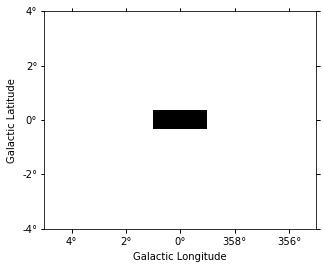

In [158]:
geom_image = geom.to_image()

#regions = CircleSkyRegion(center=spatial_model.position, radius=0.3 * u.deg)

regions = RectangleSkyRegion(center=spatial_model.position, width=2 * u.deg, height=0.7 * u.deg, angle=0 * u.deg)

exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)
exclusion_mask.plot();

In [159]:
ring_bkg = RingBackgroundEstimator(r_in="0.3 deg", width="0.3 deg")

In [162]:
def map_ring_background(observations):
    im = MapMakerRing(
        geom=geom,
        offset_max=2.0 * u.deg,
        exclusion_mask=exclusion_mask,
        background_estimator=ring_bkg,
    )
    for obs in observations:
        im._get_obs_maker(obs)

    images = im.run_images(observations, spectrum=spectrum)
    
    return images

def excess_significance_from_maps(images):
    scale = geom.pixel_scales[0].to("deg")
    # Using a convolution radius of 0.1 degrees
    theta = 0.1 * u.deg / scale
    tophat = Tophat2DKernel(theta)
    tophat.normalize("peak")

    lima_maps = compute_lima_on_off_image(
        images["on"],
        images["off"],
        images["exposure_on"],
        images["exposure_off"],
        tophat,
    )
    significance_map = lima_maps["significance"]
    excess_map = lima_maps["excess"]
    
    return significance_map, excess_map
    

In [225]:
## version alternative des deux fonctions précédentes qui somment sur l'axe des énergies en laissant un bin en énergie

## marche pas pour l'instant, car la méthode run_images de la classe MapMakerRing ne marche pas avec keepdims=True

def map_ring_background3D(observations):
    im = MapMakerRing(
        geom=geom,
        offset_max=2.0 * u.deg,
        exclusion_mask=exclusion_mask,
        background_estimator=ring_bkg,
    )
    for obs in observations:
        im._get_obs_maker(obs)

    images = im.run_images(observations, spectrum=spectrum,keepdims=True)
    
    return images

def excess_significance_from_maps3D(images):
    scale = geom.pixel_scales[0].to("deg")
    # Using a convolution radius of 0.1 degrees
    theta = 0.1 * u.deg / scale
    tophat = Tophat2DKernel(theta)
    tophat.normalize("peak")

    lima_maps = compute_lima_on_off_image(
        images["on"],
        images["off"],
        images["exposure_on"],
        images["exposure_off"],
        tophat,
    )
    significance_map = lima_maps["significance"]
    excess_map = lima_maps["excess"]
    
    return significance_map, excess_map

In [226]:
test = map_ring_background3D(obs2004)

ValueError: Map Arithmetics: Inconsistent geometries.

In [163]:
%%time

map2004 = map_ring_background(obs2004)
map2005 = map_ring_background(obs2005)
map2006 = map_ring_background(obs2006)
map2007 = map_ring_background(obs2007)
map2008 = map_ring_background(obs2008)
map2009 = map_ring_background(obs2009)
map2010 = map_ring_background(obs2010)
map2011 = map_ring_background(obs2011)
map2012 = map_ring_background(obs2012)
map2013 = map_ring_background(obs2013)
map2014 = map_ring_background(obs2014)
map2015 = map_ring_background(obs2015)
map2016 = map_ring_background(obs2016)
map2017 = map_ring_background(obs2017)
map2018 = map_ring_background(obs2018)
map2019 = map_ring_background(obs2019)

CPU times: user 34min 33s, sys: 9min 41s, total: 44min 14s
Wall time: 2d 18h 17min 49s


In [164]:
%%time

significance_map2004, excess_map2004 = excess_significance_from_maps(map2004)
significance_map2005, excess_map2005 = excess_significance_from_maps(map2005)
significance_map2006, excess_map2006 = excess_significance_from_maps(map2006)
significance_map2007, excess_map2007 = excess_significance_from_maps(map2007)
significance_map2008, excess_map2008 = excess_significance_from_maps(map2008)
significance_map2009, excess_map2009 = excess_significance_from_maps(map2009)
significance_map2010, excess_map2010 = excess_significance_from_maps(map2010)
significance_map2011, excess_map2011 = excess_significance_from_maps(map2011)
significance_map2012, excess_map2012 = excess_significance_from_maps(map2012)
significance_map2013, excess_map2013 = excess_significance_from_maps(map2013)
significance_map2014, excess_map2014 = excess_significance_from_maps(map2014)
significance_map2015, excess_map2015 = excess_significance_from_maps(map2015)
significance_map2016, excess_map2016 = excess_significance_from_maps(map2016)
significance_map2017, excess_map2017 = excess_significance_from_maps(map2017)
significance_map2018, excess_map2018 = excess_significance_from_maps(map2018)
significance_map2019, excess_map2019 = excess_significance_from_maps(map2019)

CPU times: user 725 ms, sys: 273 ms, total: 998 ms
Wall time: 1.02 s


In [197]:
map2004

{'on': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : ['lon', 'lat']
 	shape : (500, 400)
 	ndim  : 2
 	unit  : 
 	dtype : float32, 'exposure_on': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : ['lon', 'lat']
 	shape : (500, 400)
 	ndim  : 2
 	unit  : 
 	dtype : float32, 'off': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : ['lon', 'lat']
 	shape : (500, 400)
 	ndim  : 2
 	unit  : 
 	dtype : float32, 'exposure_off': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : ['lon', 'lat']
 	shape : (500, 400)
 	ndim  : 2
 	unit  : 
 	dtype : float32, 'exposure': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : ['lon', 'lat']
 	shape : (500, 400)
 	ndim  : 2
 	unit  : m2 s
 	dtype : float32}

In [189]:
import numpy as np
from astropy.coordinates import SkyCoord
from gammapy.maps import MapCoord

lon = [0.0, 1.0]
lat = [1.0, 2.0]
energy = [100, 1000]
skycoord = SkyCoord(lon, lat, unit='deg', frame='galactic')

# Create a MapCoord from a tuple (no explicit axis names)
c = MapCoord.create((lon, lat, energy))
print(c[0], c['lon'], c.lon)
print(c[1], c['lat'], c.lat)
print(c[2], c['axis0'])

# Create a MapCoord from a tuple + SkyCoord (no explicit axis names)
c = MapCoord.create((skycoord, energy))
print(c[0], c['lon'], c.lon)
print(c[1], c['lat'], c.lat)
print(c[2], c['axis0'])

[0. 1.] [0. 1.] [0. 1.]
[1. 2.] [1. 2.] [1. 2.]
[ 100 1000] [ 100 1000]
[0. 1.] [0. 1.] [0. 1.]
[1. 2.] [1. 2.] [1. 2.]
[ 100 1000] [ 100 1000]


In [190]:
m = Map.create(binsz=0.1, map_type='wcs', width=10.0)

m.interp_by_coord(([-0.05, -0.05], [0.05, 0.05]), interp='linear')
m.interp_by_coord(([-0.05, -0.05], [0.05, 0.05]), interp='cubic')

array([0., 0.], dtype=float32)

In [174]:
path2 = Path("analysis2D_GC_temp_Emin500GeV_offsetmax2")
path2.mkdir(exist_ok=True)

path3 = Path(str(path2 / "maps"))
path3.mkdir(exist_ok=True)

path4 = Path(str(path2 / "images"))
path4.mkdir(exist_ok=True)

path2004 = Path(str(path3 / "2004"))
path2004.mkdir(exist_ok=True)

path2005 = Path(str(path3 / "2005"))
path2005.mkdir(exist_ok=True)

path2006 = Path(str(path3 / "2006"))
path2006.mkdir(exist_ok=True)

path2007 = Path(str(path3 / "2007"))
path2007.mkdir(exist_ok=True)

path2008 = Path(str(path3 / "2008"))
path2008.mkdir(exist_ok=True)

path2009 = Path(str(path3 / "2009"))
path2009.mkdir(exist_ok=True)

path2010 = Path(str(path3 / "2010"))
path2010.mkdir(exist_ok=True)

path2011 = Path(str(path3 / "2011"))
path2011.mkdir(exist_ok=True)

path2012 = Path(str(path3 / "2012"))
path2012.mkdir(exist_ok=True)

path2013 = Path(str(path3 / "2013"))
path2013.mkdir(exist_ok=True)

path2014 = Path(str(path3 / "2014"))
path2014.mkdir(exist_ok=True)

path2015 = Path(str(path3 / "2015"))
path2015.mkdir(exist_ok=True)

path2016 = Path(str(path3 / "2016"))
path2016.mkdir(exist_ok=True)

path2017 = Path(str(path3 / "2017"))
path2017.mkdir(exist_ok=True)

path2018 = Path(str(path3 / "2018"))
path2018.mkdir(exist_ok=True)

path2019 = Path(str(path3 / "2019"))
path2019.mkdir(exist_ok=True)

In [178]:
map2004['on'].write(str(path2004 / "on.fits"), overwrite=True)
map2004['exposure_on'].write(str(path2004 / "exposure_on.fits"), overwrite=True)
map2004['off'].write(str(path2004 / "off.fits"), overwrite=True)
map2004['exposure_off'].write(str(path2004 / "exposure_off.fits"), overwrite=True)
map2004['exposure'].write(str(path2004 / "exposure.fits"), overwrite=True)

map2005['on'].write(str(path2005 / "on.fits"), overwrite=True)
map2005['exposure_on'].write(str(path2005 / "exposure_on.fits"), overwrite=True)
map2005['off'].write(str(path2005 / "off.fits"), overwrite=True)
map2005['exposure_off'].write(str(path2005 / "exposure_off.fits"), overwrite=True)
map2005['exposure'].write(str(path2005 / "exposure.fits"), overwrite=True)

map2006['on'].write(str(path2006 / "on.fits"), overwrite=True)
map2006['exposure_on'].write(str(path2006 / "exposure_on.fits"), overwrite=True)
map2006['off'].write(str(path2006 / "off.fits"), overwrite=True)
map2006['exposure_off'].write(str(path2006 / "exposure_off.fits"), overwrite=True)
map2006['exposure'].write(str(path2006 / "exposure.fits"), overwrite=True)

map2007['on'].write(str(path2007 / "on.fits"), overwrite=True)
map2007['exposure_on'].write(str(path2007 / "exposure_on.fits"), overwrite=True)
map2007['off'].write(str(path2007 / "off.fits"), overwrite=True)
map2007['exposure_off'].write(str(path2007 / "exposure_off.fits"), overwrite=True)
map2007['exposure'].write(str(path2007 / "exposure.fits"), overwrite=True)

map2008['on'].write(str(path2008 / "on.fits"), overwrite=True)
map2008['exposure_on'].write(str(path2008 / "exposure_on.fits"), overwrite=True)
map2008['off'].write(str(path2008 / "off.fits"), overwrite=True)
map2008['exposure_off'].write(str(path2008 / "exposure_off.fits"), overwrite=True)
map2008['exposure'].write(str(path2008 / "exposure.fits"), overwrite=True)

map2009['on'].write(str(path2009 / "on.fits"), overwrite=True)
map2009['exposure_on'].write(str(path2009 / "exposure_on.fits"), overwrite=True)
map2009['off'].write(str(path2009 / "off.fits"), overwrite=True)
map2009['exposure_off'].write(str(path2009 / "exposure_off.fits"), overwrite=True)
map2009['exposure'].write(str(path2009 / "exposure.fits"), overwrite=True)

In [179]:
map2010['on'].write(str(path2010 / "on.fits"), overwrite=True)
map2010['exposure_on'].write(str(path2010 / "exposure_on.fits"), overwrite=True)
map2010['off'].write(str(path2010 / "off.fits"), overwrite=True)
map2010['exposure_off'].write(str(path2010 / "exposure_off.fits"), overwrite=True)
map2010['exposure'].write(str(path2010 / "exposure.fits"), overwrite=True)

map2011['on'].write(str(path2011 / "on.fits"), overwrite=True)
map2011['exposure_on'].write(str(path2011 / "exposure_on.fits"), overwrite=True)
map2011['off'].write(str(path2011 / "off.fits"), overwrite=True)
map2011['exposure_off'].write(str(path2011 / "exposure_off.fits"), overwrite=True)
map2011['exposure'].write(str(path2011 / "exposure.fits"), overwrite=True)

map2012['on'].write(str(path2012 / "on.fits"), overwrite=True)
map2012['exposure_on'].write(str(path2012 / "exposure_on.fits"), overwrite=True)
map2012['off'].write(str(path2012 / "off.fits"), overwrite=True)
map2012['exposure_off'].write(str(path2012 / "exposure_off.fits"), overwrite=True)
map2012['exposure'].write(str(path2012 / "exposure.fits"), overwrite=True)

map2013['on'].write(str(path2013 / "on.fits"), overwrite=True)
map2013['exposure_on'].write(str(path2013 / "exposure_on.fits"), overwrite=True)
map2013['off'].write(str(path2013 / "off.fits"), overwrite=True)
map2013['exposure_off'].write(str(path2013 / "exposure_off.fits"), overwrite=True)
map2013['exposure'].write(str(path2013 / "exposure.fits"), overwrite=True)

map2014['on'].write(str(path2014 / "on.fits"), overwrite=True)
map2014['exposure_on'].write(str(path2014 / "exposure_on.fits"), overwrite=True)
map2014['off'].write(str(path2014 / "off.fits"), overwrite=True)
map2014['exposure_off'].write(str(path2014 / "exposure_off.fits"), overwrite=True)
map2014['exposure'].write(str(path2014 / "exposure.fits"), overwrite=True)

map2015['on'].write(str(path2015 / "on.fits"), overwrite=True)
map2015['exposure_on'].write(str(path2015 / "exposure_on.fits"), overwrite=True)
map2015['off'].write(str(path2015 / "off.fits"), overwrite=True)
map2015['exposure_off'].write(str(path2015 / "exposure_off.fits"), overwrite=True)
map2015['exposure'].write(str(path2015 / "exposure.fits"), overwrite=True)

map2016['on'].write(str(path2016 / "on.fits"), overwrite=True)
map2016['exposure_on'].write(str(path2016 / "exposure_on.fits"), overwrite=True)
map2016['off'].write(str(path2016 / "off.fits"), overwrite=True)
map2016['exposure_off'].write(str(path2016 / "exposure_off.fits"), overwrite=True)
map2016['exposure'].write(str(path2016 / "exposure.fits"), overwrite=True)

map2017['on'].write(str(path2017 / "on.fits"), overwrite=True)
map2017['exposure_on'].write(str(path2017 / "exposure_on.fits"), overwrite=True)
map2017['off'].write(str(path2017 / "off.fits"), overwrite=True)
map2017['exposure_off'].write(str(path2017 / "exposure_off.fits"), overwrite=True)
map2017['exposure'].write(str(path2017 / "exposure.fits"), overwrite=True)

map2018['on'].write(str(path2018 / "on.fits"), overwrite=True)
map2018['exposure_on'].write(str(path2018 / "exposure_on.fits"), overwrite=True)
map2018['off'].write(str(path2018 / "off.fits"), overwrite=True)
map2018['exposure_off'].write(str(path2018 / "exposure_off.fits"), overwrite=True)
map2018['exposure'].write(str(path2018 / "exposure.fits"), overwrite=True)

map2019['on'].write(str(path2019 / "on.fits"), overwrite=True)
map2019['exposure_on'].write(str(path2019 / "exposure_on.fits"), overwrite=True)
map2019['off'].write(str(path2019 / "off.fits"), overwrite=True)
map2019['exposure_off'].write(str(path2019 / "exposure_off.fits"), overwrite=True)
map2019['exposure'].write(str(path2019 / "exposure.fits"), overwrite=True)

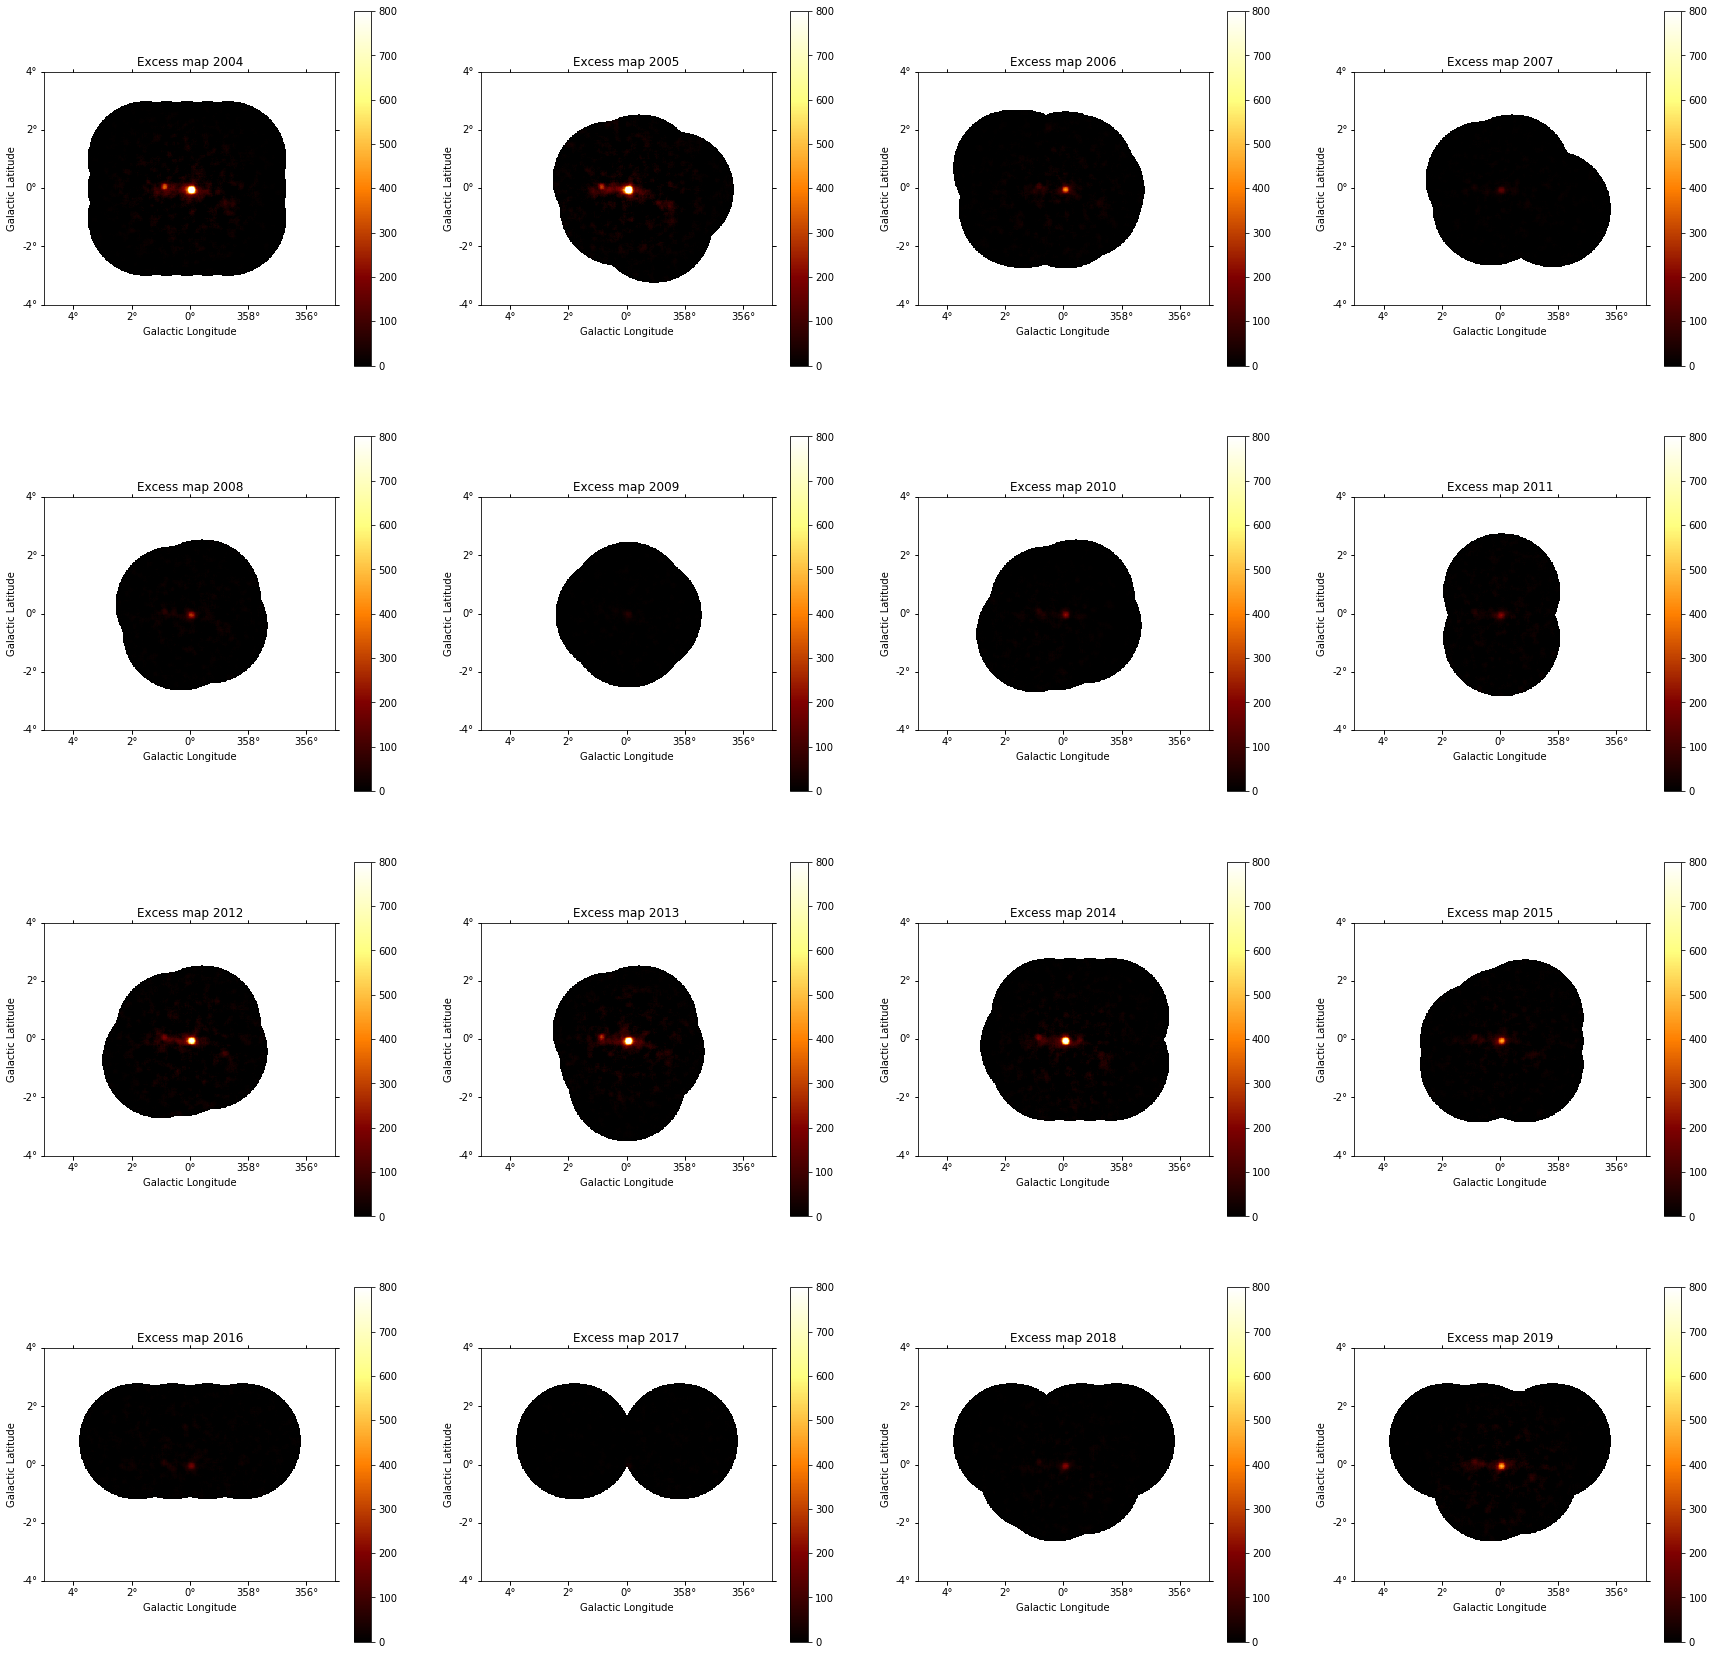

In [194]:
plt.figure(figsize=(30, 30))

ax1 = plt.subplot(4,4,1, projection=excess_map2004.geom.wcs)
ax2 = plt.subplot(4,4,2, projection=excess_map2005.geom.wcs)
ax3 = plt.subplot(4, 4, 3, projection=excess_map2006.geom.wcs)
ax4 = plt.subplot(4, 4, 4, projection=excess_map2007.geom.wcs)
ax5 = plt.subplot(4,4,5, projection=excess_map2008.geom.wcs)
ax6 = plt.subplot(4,4,6, projection=excess_map2009.geom.wcs)
ax7 = plt.subplot(4, 4, 7, projection=excess_map2010.geom.wcs)
ax8 = plt.subplot(4, 4, 8, projection=excess_map2011.geom.wcs)
ax9 = plt.subplot(4,4,9, projection=excess_map2012.geom.wcs)
ax10 = plt.subplot(4,4,10, projection=excess_map2013.geom.wcs)
ax11 = plt.subplot(4, 4, 11, projection=excess_map2014.geom.wcs)
ax12 = plt.subplot(4, 4, 12, projection=excess_map2015.geom.wcs)
ax13 = plt.subplot(4,4,13, projection=excess_map2016.geom.wcs)
ax14 = plt.subplot(4, 4, 14, projection=excess_map2017.geom.wcs)
ax15 = plt.subplot(4, 4, 15, projection=excess_map2018.geom.wcs)
ax16 = plt.subplot(4,4,16, projection=excess_map2019.geom.wcs)


ax1.set_title("Excess map 2004")
excess_map2004.plot(ax=ax1, vmin=0, vmax=800 , add_cbar=True)

ax2.set_title("Excess map 2005")
excess_map2005.plot(ax=ax2, vmin=0, vmax=800, add_cbar=True)

ax3.set_title("Excess map 2006")
excess_map2006.plot(ax=ax3, vmin=0, vmax=800, add_cbar=True)

ax4.set_title("Excess map 2007")
excess_map2007.plot(ax=ax4, vmin=0, vmax=800, add_cbar=True)

ax5.set_title("Excess map 2008")
excess_map2008.plot(ax=ax5, vmin=0, vmax=800, add_cbar=True)

ax6.set_title("Excess map 2009")
excess_map2009.plot(ax=ax6, vmin=0, vmax=800, add_cbar=True)

ax7.set_title("Excess map 2010")
excess_map2010.plot(ax=ax7, vmin=0, vmax=800, add_cbar=True)

ax8.set_title("Excess map 2011")
excess_map2011.plot(ax=ax8, vmin=0, vmax=800, add_cbar=True)

ax9.set_title("Excess map 2012")
excess_map2012.plot(ax=ax9, vmin=0, vmax=800, add_cbar=True)

ax10.set_title("Excess map 2013")
excess_map2013.plot(ax=ax10, vmin=0, vmax=800, add_cbar=True)

ax11.set_title("Excess map 2014")
excess_map2014.plot(ax=ax11, vmin=0, vmax=800, add_cbar=True)

ax12.set_title("Excess map 2015")
excess_map2015.plot(ax=ax12, vmin=0, vmax=800, add_cbar=True)

ax13.set_title("Excess map 2016")
excess_map2016.plot(ax=ax13, vmin=0, vmax=800, add_cbar=True)

ax14.set_title("Excess map 2017")
excess_map2017.plot(ax=ax14, vmin=0, vmax=800, add_cbar=True)

ax15.set_title("Excess map 2018")
excess_map2018.plot(ax=ax15, vmin=0, vmax=800, add_cbar=True)

ax16.set_title("Excess map 2019")
excess_map2019.plot(ax=ax16, vmin=0, vmax=800, add_cbar=True)

plt.savefig(str(path4 / "cartes_exces.pdf"))

In [176]:
flux_map2004 = excess_map2004/map2004["exposure"]
flux_map2005 = excess_map2005/map2005["exposure"]
flux_map2006 = excess_map2006/map2006["exposure"]
flux_map2007 = excess_map2007/map2007["exposure"]
flux_map2008 = excess_map2008/map2008["exposure"]
flux_map2009 = excess_map2009/map2009["exposure"]
flux_map2010 = excess_map2010/map2010["exposure"]
flux_map2011 = excess_map2011/map2011["exposure"]
flux_map2012 = excess_map2012/map2012["exposure"]
flux_map2013 = excess_map2013/map2013["exposure"]
flux_map2014 = excess_map2014/map2014["exposure"]
flux_map2015 = excess_map2015/map2015["exposure"]
flux_map2016 = excess_map2016/map2016["exposure"]
flux_map2017 = excess_map2017/map2017["exposure"]
flux_map2018 = excess_map2018/map2018["exposure"]
flux_map2019 = excess_map2019/map2019["exposure"]

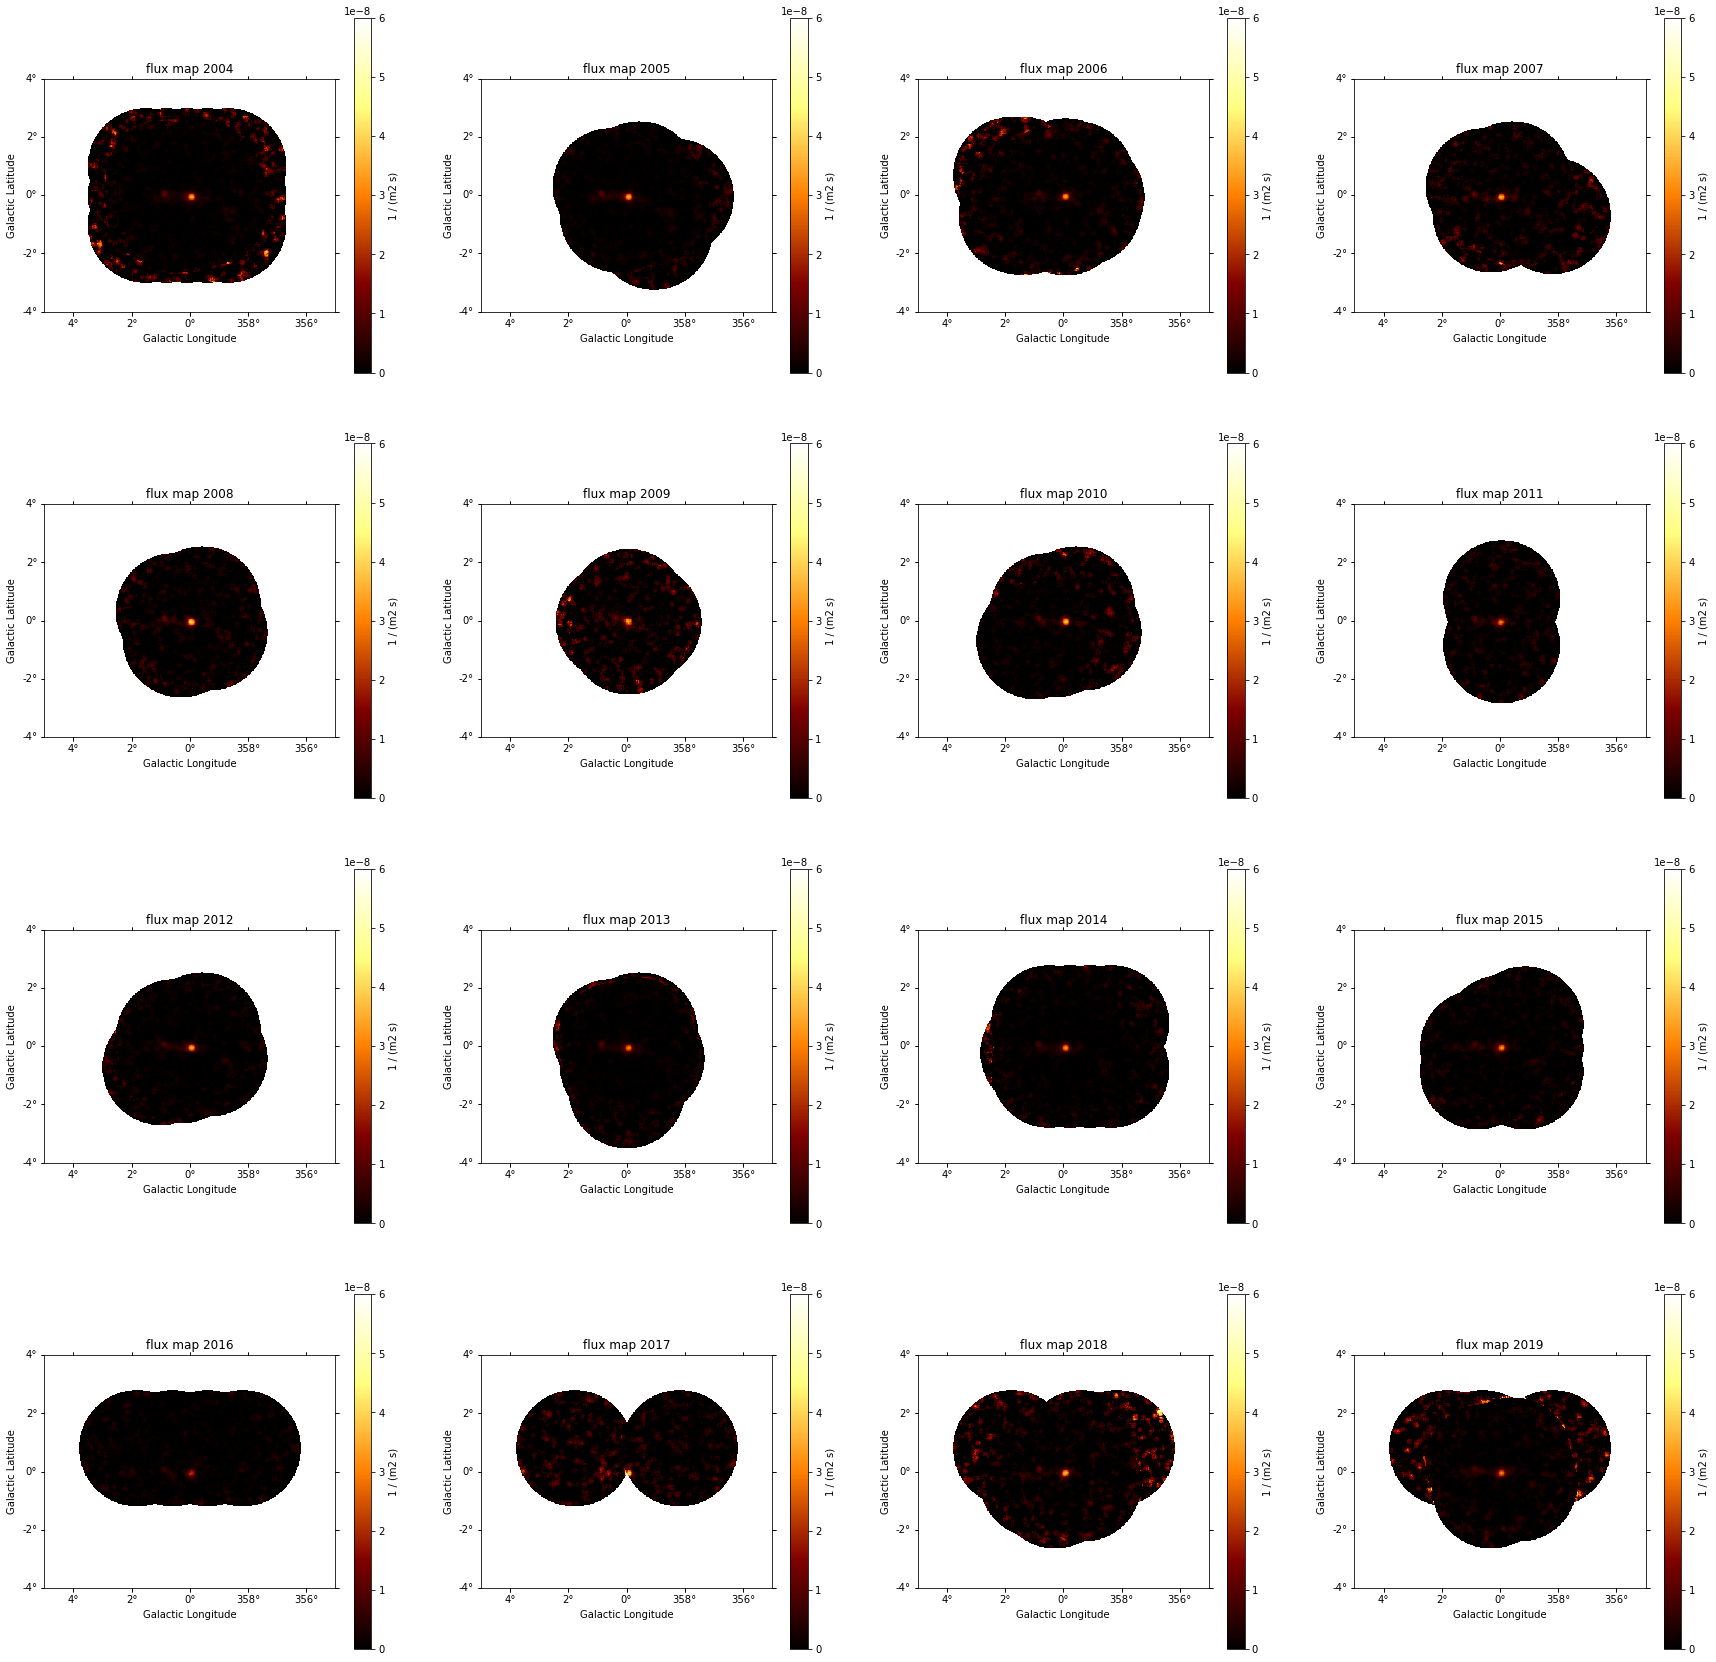

In [195]:
plt.figure(figsize=(30, 30))

ax1 = plt.subplot(4,4,1, projection=flux_map2004.geom.wcs)
ax2 = plt.subplot(4,4,2, projection=flux_map2005.geom.wcs)
ax3 = plt.subplot(4, 4, 3, projection=flux_map2006.geom.wcs)
ax4 = plt.subplot(4, 4, 4, projection=flux_map2007.geom.wcs)
ax5 = plt.subplot(4,4,5, projection=flux_map2008.geom.wcs)
ax6 = plt.subplot(4,4,6, projection=flux_map2009.geom.wcs)
ax7 = plt.subplot(4, 4, 7, projection=flux_map2010.geom.wcs)
ax8 = plt.subplot(4, 4, 8, projection=flux_map2011.geom.wcs)
ax9 = plt.subplot(4,4,9, projection=flux_map2012.geom.wcs)
ax10 = plt.subplot(4,4,10, projection=flux_map2013.geom.wcs)
ax11 = plt.subplot(4, 4, 11, projection=flux_map2014.geom.wcs)
ax12 = plt.subplot(4, 4, 12, projection=flux_map2015.geom.wcs)
ax13 = plt.subplot(4,4,13, projection=flux_map2016.geom.wcs)
ax14 = plt.subplot(4, 4, 14, projection=flux_map2017.geom.wcs)
ax15 = plt.subplot(4, 4, 15, projection=flux_map2018.geom.wcs)
ax16 = plt.subplot(4,4,16, projection=flux_map2019.geom.wcs)


ax1.set_title("flux map 2004")
flux_map2004.plot(ax=ax1, vmin=0, vmax=6e-8, add_cbar=True)

ax2.set_title("flux map 2005")
flux_map2005.plot(ax=ax2 ,vmin=0, vmax=6e-8, add_cbar=True)

ax3.set_title("flux map 2006")
flux_map2006.plot(ax=ax3, vmin=0, vmax=6e-8, add_cbar=True)

ax4.set_title("flux map 2007")
flux_map2007.plot(ax=ax4, vmin=0, vmax=6e-8, add_cbar=True)

ax5.set_title("flux map 2008")
flux_map2008.plot(ax=ax5, vmin=0, vmax=6e-8, add_cbar=True)

ax6.set_title("flux map 2009")
flux_map2009.plot(ax=ax6, vmin=0, vmax=6e-8, add_cbar=True)

ax7.set_title("flux map 2010")
flux_map2010.plot(ax=ax7, vmin=0, vmax=6e-8, add_cbar=True)

ax8.set_title("flux map 2011")
flux_map2011.plot(ax=ax8, vmin=0, vmax=6e-8, add_cbar=True)

ax9.set_title("flux map 2012")
flux_map2012.plot(ax=ax9, vmin=0, vmax=6e-8, add_cbar=True)

ax10.set_title("flux map 2013")
flux_map2013.plot(ax=ax10, vmin=0, vmax=6e-8, add_cbar=True)

ax11.set_title("flux map 2014")
flux_map2014.plot(ax=ax11, vmin=0, vmax=6e-8, add_cbar=True)

ax12.set_title("flux map 2015")
flux_map2015.plot(ax=ax12, vmin=0, vmax=6e-8, add_cbar=True)

ax13.set_title("flux map 2016")
flux_map2016.plot(ax=ax13, vmin=0, vmax=6e-8, add_cbar=True)

ax14.set_title("flux map 2017")
flux_map2017.plot(ax=ax14, vmin=0, vmax=6e-8, add_cbar=True)

ax15.set_title("flux map 2018")
flux_map2018.plot(ax=ax15, vmin=0, vmax=6e-8, add_cbar=True)

ax16.set_title("flux map 2019")
flux_map2019.plot(ax=ax16, vmin=0, vmax=6e-8, add_cbar=True)

plt.savefig(str(path4 / "cartes_flux.pdf"))

In [200]:
spatial_model = PointSpatialModel(lon_0="0.00 deg", lat_0="0.00 deg", frame="galactic")

spectral_model = PowerLaw2SpectralModel(emin=emin, emax=emax, index=2.3, amplitude="3e-12 cm-2 s-1")

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name="SgrA*")

model.parameters["index"].frozen = True  #ok, on veut pas faire changer l'index mais juste l'amplitude ici (un flux)


geom2d = map2004["exposure"].geom
region = CircleSkyRegion(center=src_pos, radius=0.6 * u.deg)
mask = geom2d.region_mask([region])

In [219]:
# on va essayer de projeter manuellement une carte 2D dans une carte 3D avec un bin sur la 3eme coordonnée

energy_axis_1bin = MapAxis.from_bounds(
    emin.value, emax.value, 1, unit="TeV", name="energy", interp="log"
)
geom_image3d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis_1bin],
)



In [201]:
# le problème ici est simplement que map2004["exposure_on"] & co n'ont pas de coordonnées 'energy', sinon les données sont là
# Le plus simple serait de modifier la fonction BackgroundModel pour que ça ne la dérange pas, 
# ou bien de rajouter une coordonnée à 1 bin à nos cartes 2D (pas implémenté car c'est seulement possible pour 1 bin)
# Ou bien : faire en sorte qu'on n'obtienne plus de cartes 2D après un sum_over_axes (ou qu'on puisse choisir de ne pas le faire), méthode pas clairement définie par ailleurs

# réponse 1 : l'option keepdims de la méthode _maps_sum_over_axes (et dont de run_images pour MapMakerRing) permet de laisser un bin en énergie
# problème : ça ne marche pas pour run_images pour MapMakerRing, problème de géométries des cartes counts et exclusion


background_model = BackgroundModel( (map2004["exposure_on"]/map2004["exposure_off"]) * map2004["off"], norm=1.1, tilt=0.0)

background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

dataset = MapDataset(
    model=model,
    counts= map2004["on"],
    exposure=map2004["exposure"],
    background_model=background_model,
    mask_fit=mask,
    psf=psf_kernel2004,
)

fit = Fit(dataset)
result = fit.run()

/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


KeyError: 'ENERGY'

In [203]:
def fit_flux_per_year(path):
    
    on = Map.read(str(path / "on.fits"))
    off = Map.read(str(path / "off.fits"))
    accepton = Map.read(str(path / "exposure_on.fits"))
    acceptoff = Map.read(str(path / "exposure_off.fits"))
    exposure = Map.read(str(path / "exposure.fits"))
    
    energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log")
    geom3D = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis])
    
    on = on.reproject(geom3D)
    off = off.reproject(geom3D)
    accepton = accepton.reproject(geom3D)
    acceptoff = acceptoff.reproject(geom3D)
    exposure = exposure.reproject(geom3D)
    
    region = CircleSkyRegion(center=src_pos, radius=0.6 * u.deg)
    mask = geom3D.region_mask([region])
    
    background_model = BackgroundModel( (accepton/acceptoff) * off, norm=1.1, tilt=0.0)
    background_model.parameters["norm"].frozen = True
    background_model.parameters["tilt"].frozen = True
    
    dataset = MapDataset(
       model=model,
       counts= on,
       exposure=exposure,
       background_model=background_model,
       mask_fit=mask,
       psf=psf_kernel2004
    )

In [202]:
geom2d

WcsGeom

	axes       : ['lon', 'lat']
	shape      : (500, 400)
	ndim       : 2
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 8.0 deg

In [196]:
maps2D2004["counts"].geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (500, 400, 1)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 8.0 deg